In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, Dense, Dropout

In [2]:
# 1. Load and preprocess dataset
df = pd.read_csv('training_dataset_no_stopwords.csv')

In [3]:
# Assume columns: 'text', 'label'
texts = df['Sentiment'].astype(str).tolist()
labels = df['Label'].astype(str).tolist()

In [4]:
# Encode labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

In [5]:
# # Assign class weights: Positive=2, Negative=2, Neutral=1
# class_weights = {}
# for label, idx in label_to_index.items():
#     if label.lower() == 'neutral':
#         class_weights[idx] = 1
#     else:
#         class_weights[idx] = 2
# print('Class weights:', class_weights)

In [6]:
# # Visualize class distribution and weights
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Class distribution
# plt.figure(figsize=(8, 4))
# sns.countplot(x=labels)
# plt.title('Class Distribution')
# plt.xlabel('Class Label')
# plt.ylabel('Number of Samples')
# plt.show()

# # Class weights visualization
# plt.figure(figsize=(8, 4))
# weight_items = sorted(class_weights.items(), key=lambda x: x[0])
# weight_labels = [list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx, _ in weight_items]
# weight_values = [w for _, w in weight_items]
# sns.barplot(x=weight_labels, y=weight_values)
# plt.title('Assigned Class Weights')
# plt.xlabel('Class Label')
# plt.ylabel('Weight')
# plt.show()

In [7]:
# # Balance the dataset by upsampling minority classes
# from sklearn.utils import resample

# # Combine texts and labels into a DataFrame
# balance_df = pd.DataFrame({'text': texts, 'label': labels})

# # Find the maximum class size
# max_size = balance_df['label'].value_counts().max()

# # Upsample each class to max_size
# balanced_list = []
# for label in balance_df['label'].unique():
#     class_subset = balance_df[balance_df['label'] == label]
#     upsampled = resample(class_subset, replace=True, n_samples=max_size, random_state=42)
#     balanced_list.append(upsampled)
# balanced_df = pd.concat(balanced_list)

# # Visualize new class distribution
# plt.figure(figsize=(8, 4))
# sns.countplot(x=balanced_df['label'])
# plt.title('Balanced Class Distribution')
# plt.xlabel('Class Label')
# plt.ylabel('Number of Samples')
# plt.show()

# # Update texts and labels for further processing
# texts = balanced_df['text'].tolist()
# labels = balanced_df['label'].tolist()

In [8]:
# # Re-encode labels after balancing
# label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
# y = np.array([label_to_index[label] for label in labels])
# num_classes = len(label_to_index)
# y_cat = to_categorical(y, num_classes=num_classes)

In [9]:
# 2. Tokenization and Embedding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

In [10]:
# 3. K-Fold Cross-Validation
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

In [11]:
# 4. Model architectures
def build_cnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_rnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        SimpleRNN(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [12]:
# 5. Training and Evaluation
results = {'CNN': [], 'RNN': [], 'LSTM': []}
for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]
    y_val_labels = y[val_idx]
    vocab_size = min(10000, len(tokenizer.word_index) + 1)

    for name, build_fn in zip(['CNN', 'RNN', 'LSTM'], [build_cnn, build_rnn, build_lstm]):
        model = build_fn(maxlen, vocab_size, num_classes)
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        acc = accuracy_score(y_val_labels, y_pred)
        prec = precision_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        mcc = matthews_corrcoef(y_val_labels, y_pred)
        mse = mean_squared_error(y_val_labels, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_labels, y_pred)
        
        results[name].append({
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'mcc': mcc,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })
        print(f"Fold {fold+1} {name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    # Track and plot training/validation loss and accuracy for each fold and model
    train_histories = {'CNN': [], 'RNN': [], 'LSTM': []}

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_cat[train_idx], y_cat[val_idx]
        y_val_labels = y[val_idx]
        vocab_size = min(10000, len(tokenizer.word_index) + 1)

        for name, build_fn in zip(['CNN', 'RNN', 'LSTM'], [build_cnn, build_rnn, build_lstm]):
            model = build_fn(maxlen, vocab_size, num_classes)
            history = model.fit(
                X_train, y_train,
                epochs=5,
                batch_size=32,
                verbose=0,
                validation_data=(X_val, y_val)
            )
            train_histories[name].append(history)


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1 CNN: Acc=0.6193, Prec=0.6143, Rec=0.6193, F1=0.6151, MCC=0.3619, MSE=0.5685, RMSE=0.7540, R2=-0.2348


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 1 RNN: Acc=0.5826, Prec=0.5664, Rec=0.5826, F1=0.5675, MCC=0.2745, MSE=0.6210, RMSE=0.7880, R2=-0.3488


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 1 LSTM: Acc=0.6172, Prec=0.6100, Rec=0.6172, F1=0.6117, MCC=0.3544, MSE=0.5739, RMSE=0.7575, R2=-0.2465


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 2 CNN: Acc=0.6181, Prec=0.6237, Rec=0.6181, F1=0.6189, MCC=0.3770, MSE=0.5926, RMSE=0.7698, R2=-0.2931


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 2 RNN: Acc=0.5791, Prec=0.5656, Rec=0.5791, F1=0.5694, MCC=0.2781, MSE=0.6377, RMSE=0.7985, R2=-0.3915


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Fold 2 LSTM: Acc=0.6164, Prec=0.6135, Rec=0.6164, F1=0.6143, MCC=0.3552, MSE=0.5670, RMSE=0.7530, R2=-0.2373


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3 CNN: Acc=0.6177, Prec=0.6165, Rec=0.6177, F1=0.6169, MCC=0.3628, MSE=0.5593, RMSE=0.7478, R2=-0.2269


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Fold 3 RNN: Acc=0.5708, Prec=0.5611, Rec=0.5708, F1=0.5638, MCC=0.2716, MSE=0.6335, RMSE=0.7959, R2=-0.3898


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Fold 3 LSTM: Acc=0.6244, Prec=0.6176, Rec=0.6244, F1=0.6185, MCC=0.3629, MSE=0.5470, RMSE=0.7396, R2=-0.1999


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


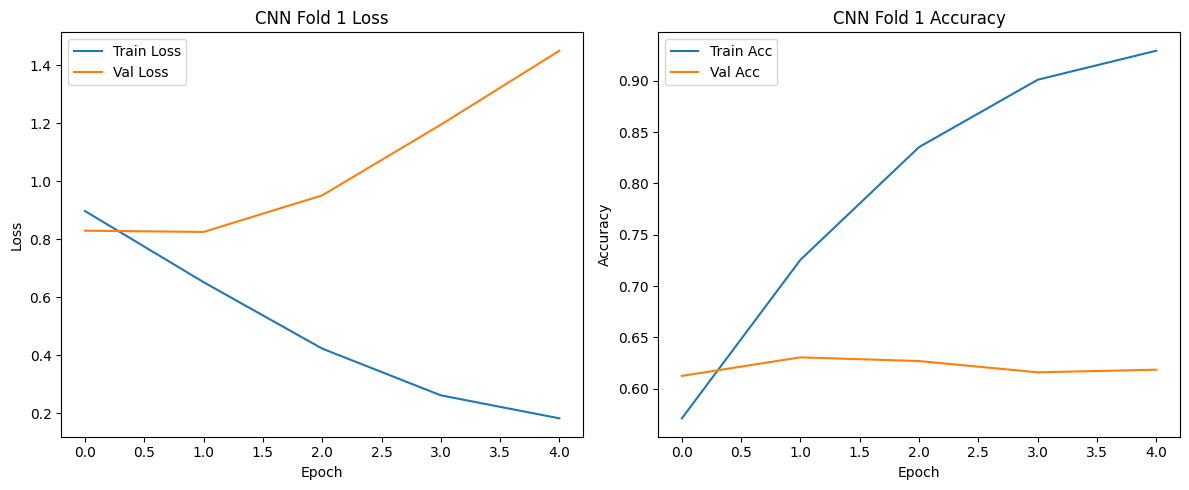

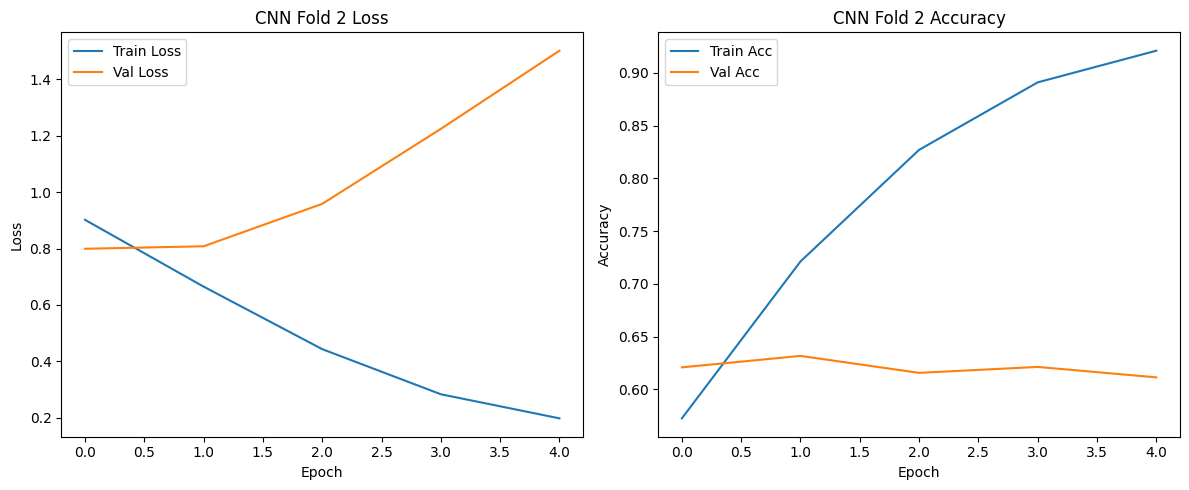

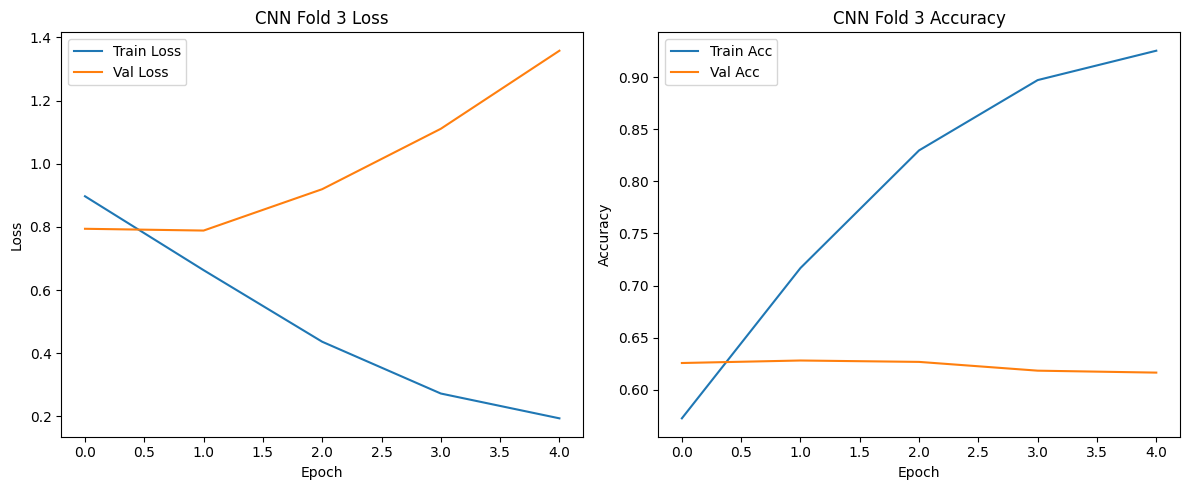

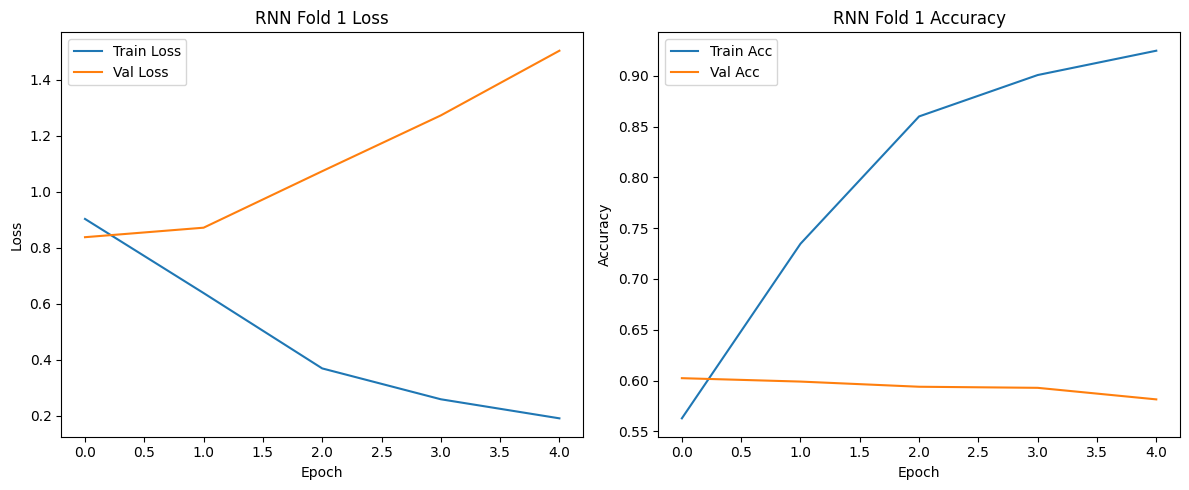

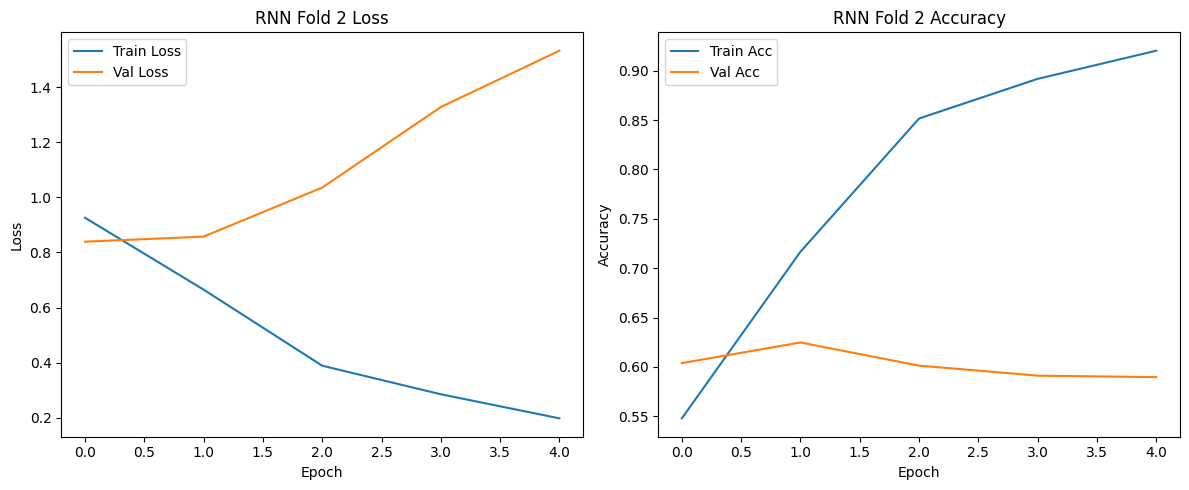

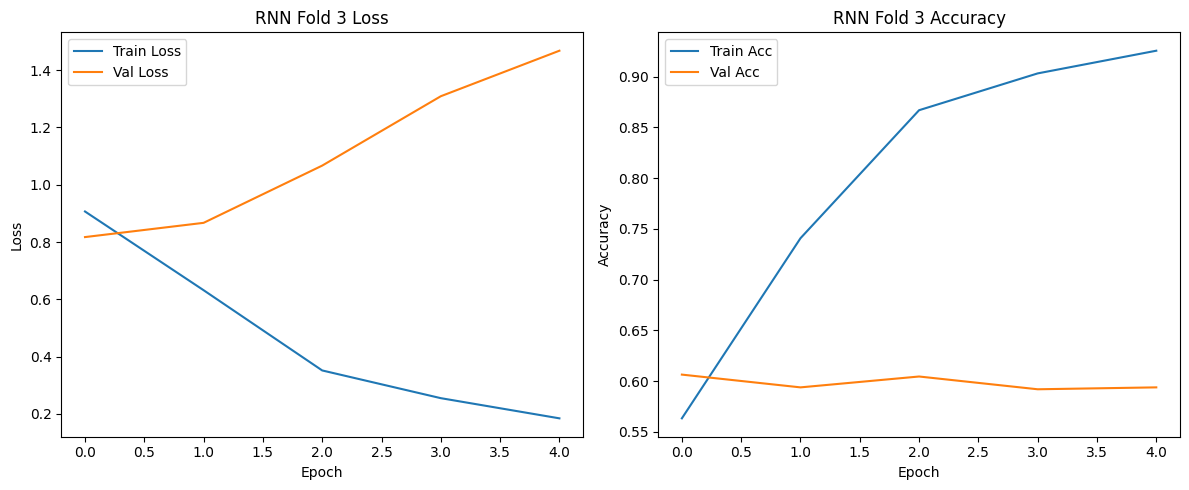

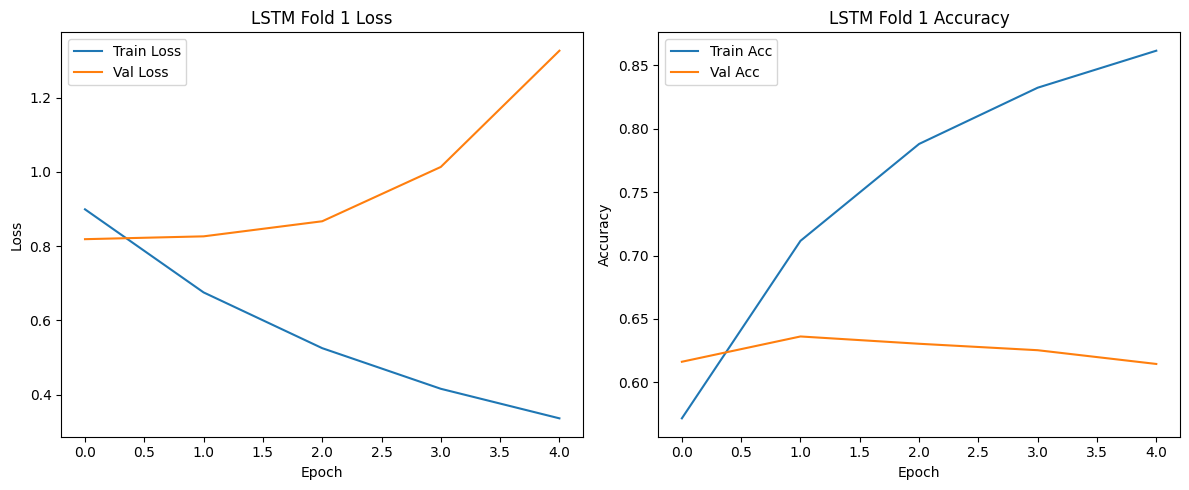

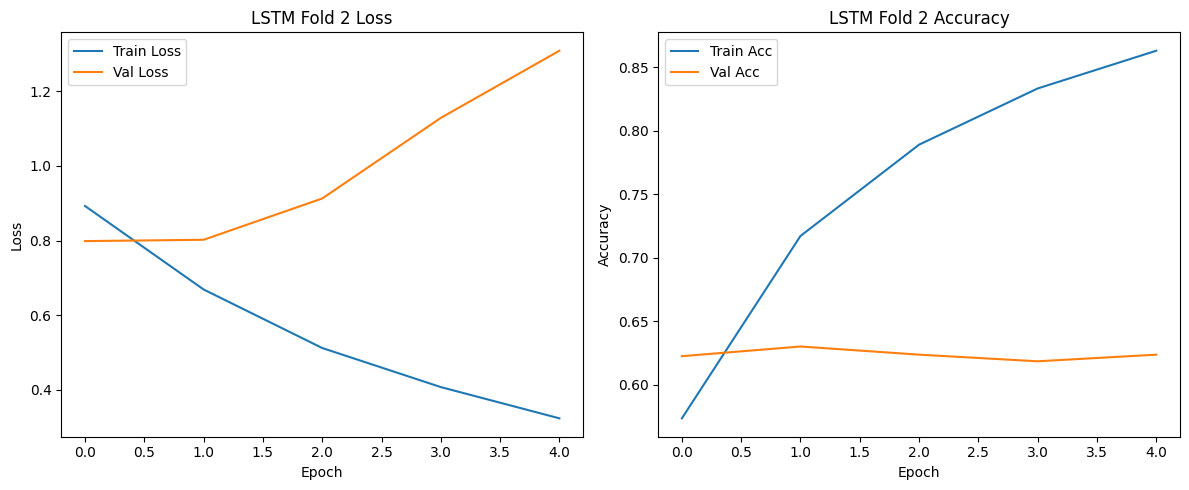

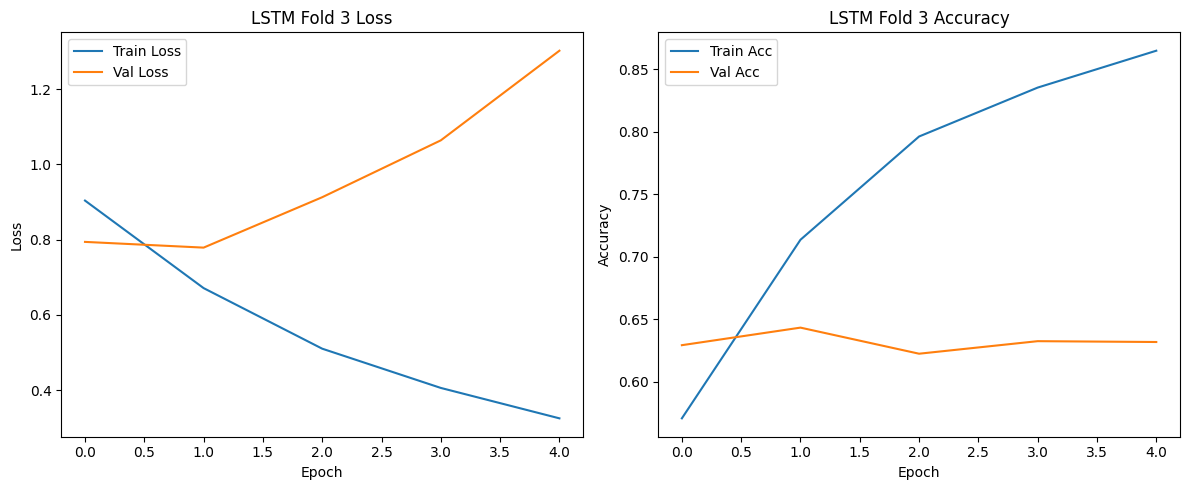

In [13]:
# Plot training/validation loss and accuracy curves
import matplotlib.pyplot as plt
for name in train_histories:
    for fold_idx, history in enumerate(train_histories[name]):
        plt.figure(figsize=(12, 5))
        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f'{name} Fold {fold_idx+1} Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        # Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Acc')
        plt.plot(history.history['val_accuracy'], label='Val Acc')
        plt.title(f'{name} Fold {fold_idx+1} Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.show()

In [14]:
# 6. Average metrics and select best model
import statistics
summary = {}
for name in results:
    avg_metrics = {metric: statistics.mean([fold[metric] for fold in results[name]]) for metric in results[name][0]}
    summary[name] = avg_metrics
    print(f"\n{name} Average Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")


CNN Average Metrics:
accuracy: 0.6184
precision: 0.6181
recall: 0.6184
f1: 0.6170
mcc: 0.3673
mse: 0.5735
rmse: 0.7572
r2: -0.2516

RNN Average Metrics:
accuracy: 0.5775
precision: 0.5643
recall: 0.5775
f1: 0.5669
mcc: 0.2747
mse: 0.6307
rmse: 0.7942
r2: -0.3767

LSTM Average Metrics:
accuracy: 0.6193
precision: 0.6137
recall: 0.6193
f1: 0.6148
mcc: 0.3575
mse: 0.5626
rmse: 0.7500
r2: -0.2279


In [15]:
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'mcc', 'mse', 'rmse', 'r2']
plot_data = []
for name in results:
    for fold_idx, fold in enumerate(results[name]):
        fold_data = {'Model': name, 'Fold': f'Fold {fold_idx + 1}'}
        fold_data.update(fold)
        plot_data.append(fold_data)
plot_df = pd.DataFrame(plot_data)

In [16]:
for metric in metrics_to_plot:
    if metric in ['mse', 'rmse']:  # For these, lower is better
        best = min(summary, key=lambda x: summary[x][metric])
    else:  # For others, higher is better
        best = max(summary, key=lambda x: summary[x][metric])
    print(f"For {metric}, the winner is {best} (score: {summary[best][metric]:.4f})")
    

print(f"\nOverall Best Model: {best}")
print(f"This is because {best} achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) \ncompared to the other two, indicating it generalizes better on this sentiment classification task.")


For accuracy, the winner is LSTM (score: 0.6193)
For precision, the winner is CNN (score: 0.6181)
For recall, the winner is LSTM (score: 0.6193)
For f1, the winner is CNN (score: 0.6170)
For mcc, the winner is CNN (score: 0.3673)
For mse, the winner is LSTM (score: 0.5626)
For rmse, the winner is LSTM (score: 0.7500)
For r2, the winner is LSTM (score: -0.2279)

Overall Best Model: LSTM
This is because LSTM achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) 
compared to the other two, indicating it generalizes better on this sentiment classification task.


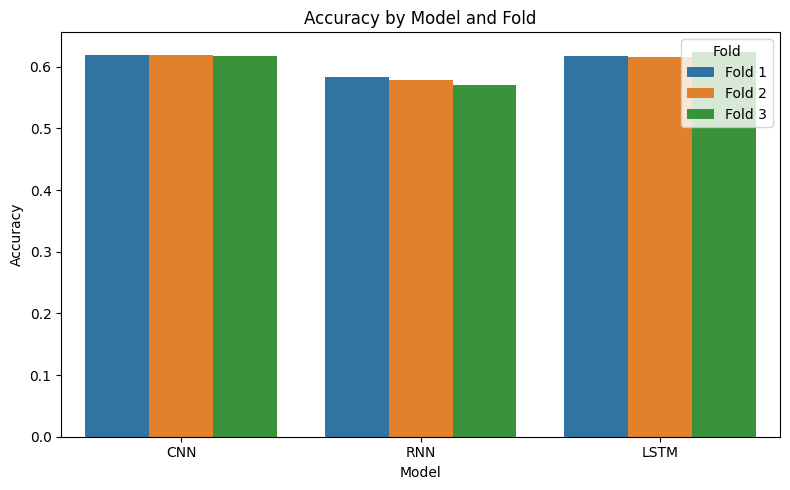

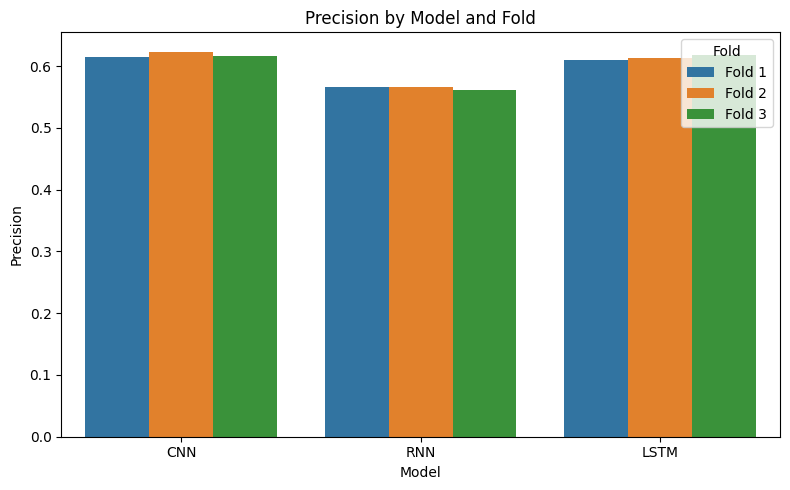

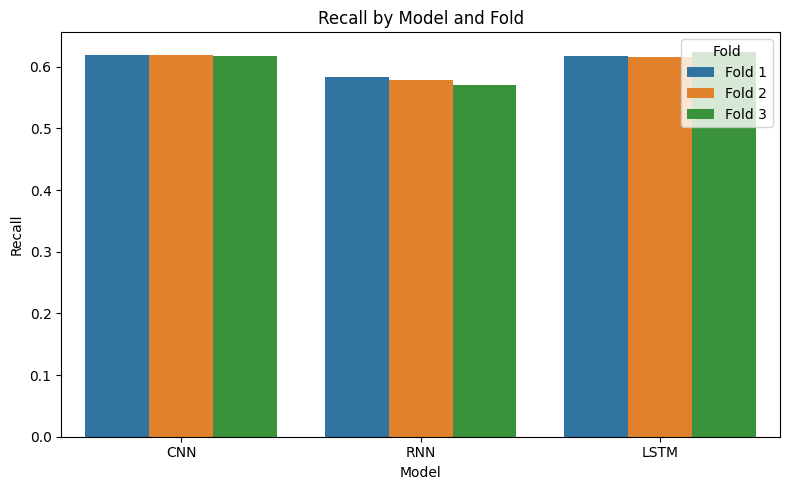

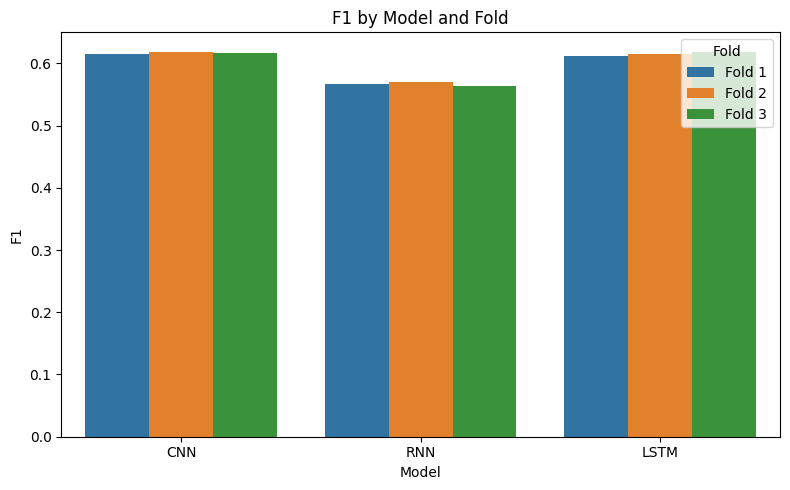

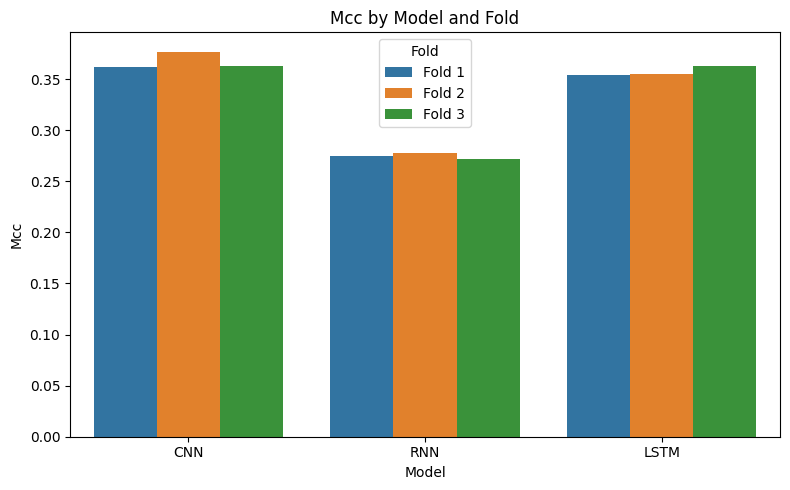

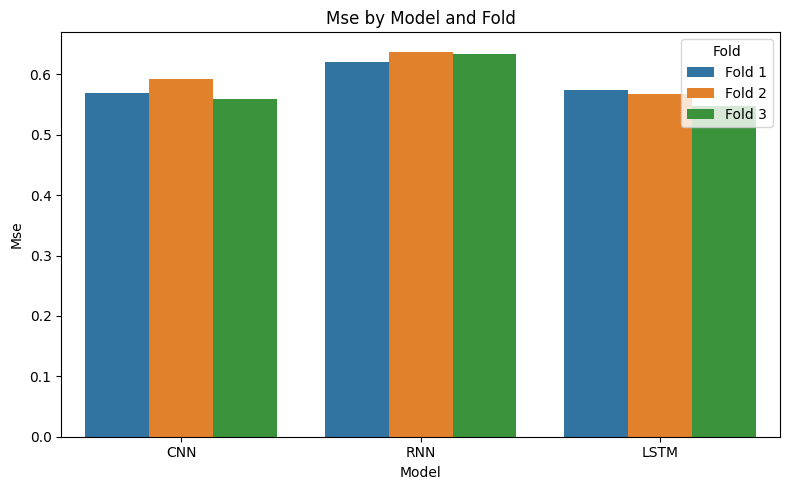

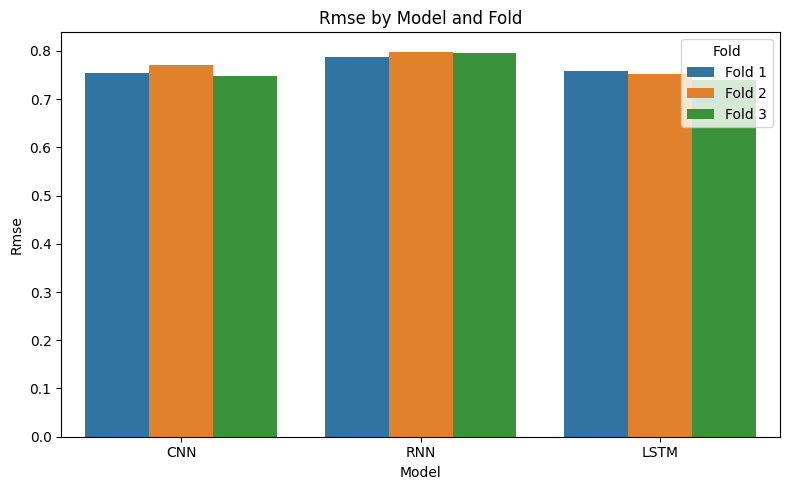

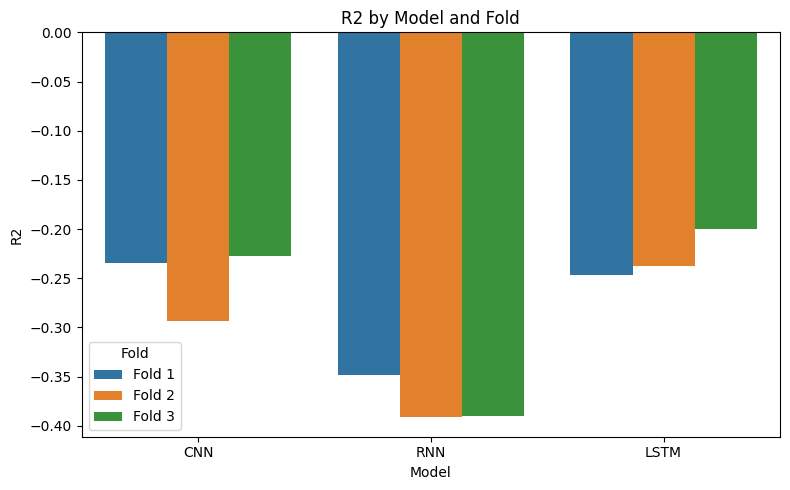

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=plot_df, x='Model', y=metric, hue='Fold')
    plt.title(f'{metric.capitalize()} by Model and Fold')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()